# Waiting time analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read logs

In [2]:
job_chars = pd.read_parquet('data/job_chars.parquet')

In [3]:
job_chars

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
index,,,,,,,,,,
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
0002286e1d7e428d,clmedium,NaT,NaN,2020-09-28 07:55:47+02:00,60.716667,1.0,0.989072,0.04895,0.502306,0.005687
00024ec1bf68e413,clfo2,NaT,NaN,2020-06-29 01:05:19+02:00,0.116667,1.0,0.000000,0.00000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
fffbfaccf8c9fbf4,clexpres,NaT,NaN,2020-03-27 15:05:44+01:00,5.033333,1.0,0.190265,0.11484,0.000000,0.000000
fffd086716a4d46c,cllong,NaT,NaN,2020-09-14 00:40:27+02:00,143.616667,1.0,0.994714,0.46693,0.025502,0.000300
ffff38341e8c6b3b,clmedium,2020-08-13 22:35:57+02:00,401.333333,2020-08-14 05:17:17+02:00,621.766667,8.0,31.858035,5.24000,0.662259,0.550000


In [4]:
detected_waiting_time = job_chars['Waited'].notna()

In [5]:
batch_classes = ['clexpres', 'clmedium', 'cllong', 'clbigmem', 'clfo2','feque']

In [6]:
jobs_waited = job_chars[detected_waiting_time]

In [7]:
jobs_waited

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
index,,,,,,,,,,
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
00037a43b4a1e676,clmedium,2020-07-01 13:58:31+02:00,0.000000,NaT,NaN,1.0,NaN,NaN,NaN,NaN
0003a37a7a8562f1,clexpres,2020-03-06 11:52:11+01:00,70.450000,NaT,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
fffabf82e38ce12d,clmedium,2020-03-11 14:13:06+01:00,1763.016667,2020-03-12 19:36:07+01:00,1802.366667,1.0,31.920809,1.90000,0.151690,0.035250
fffb0eb6f2ab000b,clmedium,2020-09-20 17:14:20+02:00,757.650000,2020-09-21 05:51:59+02:00,2007.416667,1.0,19.946999,15.33000,0.469802,0.070500
ffff38341e8c6b3b,clmedium,2020-08-13 22:35:57+02:00,401.333333,2020-08-14 05:17:17+02:00,621.766667,8.0,31.858035,5.24000,0.662259,0.550000


In [16]:
def Scatter(df, x, batch_class):
    ax1 = df.loc[df['Batch_class'].str.contains(batch_class)].plot.scatter(x,'Waited',c='midnightblue')
    ax1.set_title(batch_class)
    ax1.set_ylabel('Waiting time in minutes')
    ax2 = ax1.twinx()
    mn, mx = ax1.get_ylim()
    ax2.set_ylim(mn/60, mx/60)
    ax2.set_ylabel('Waiting times in hours')

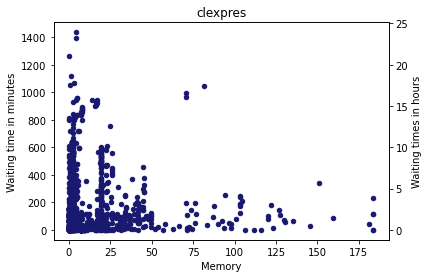

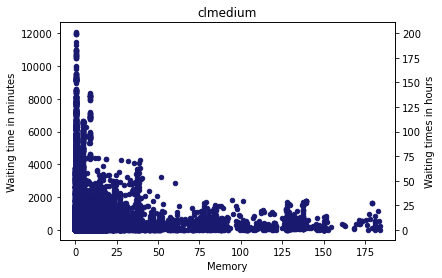

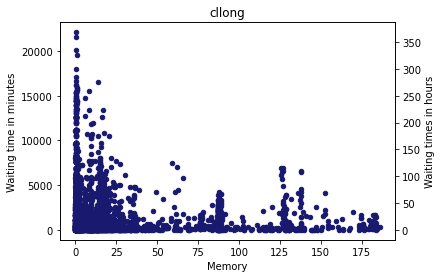

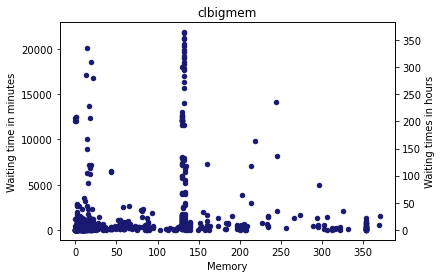

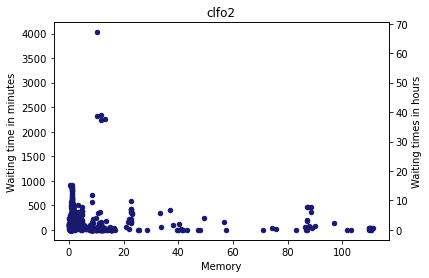

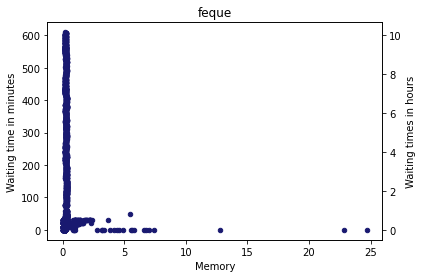

In [17]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'Memory',batch_class)

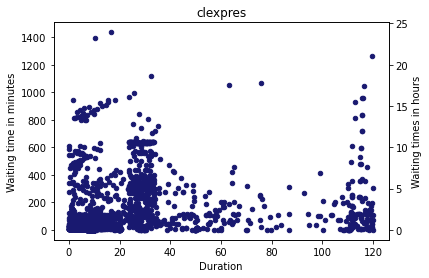

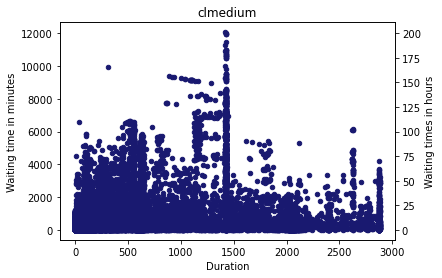

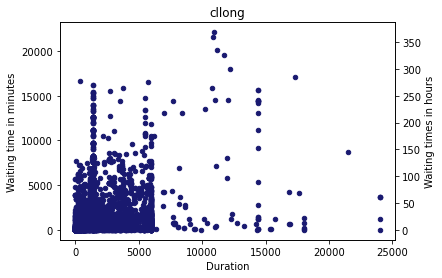

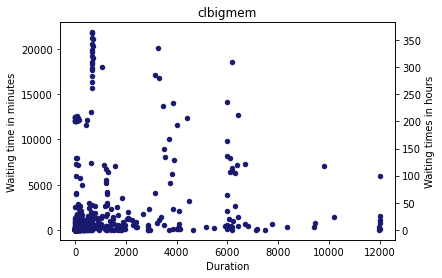

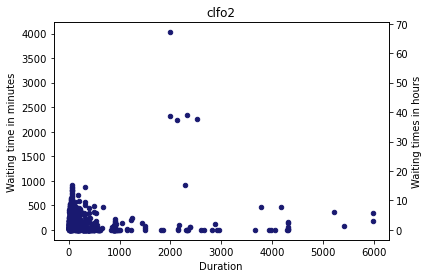

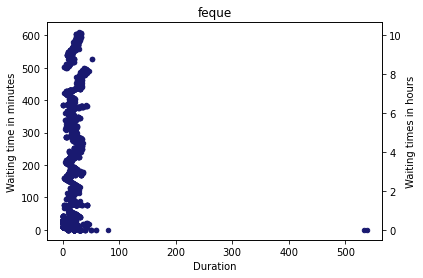

In [18]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'Duration',batch_class)

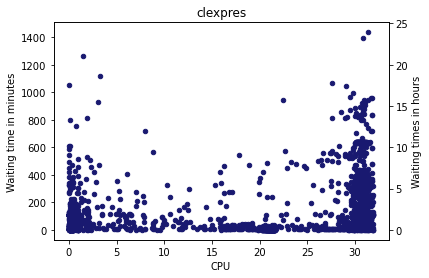

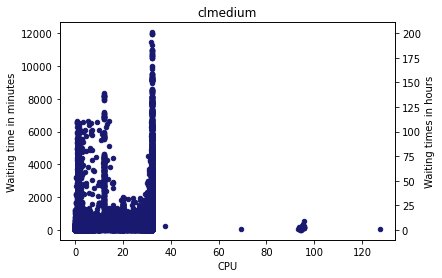

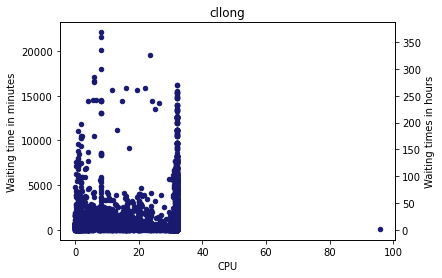

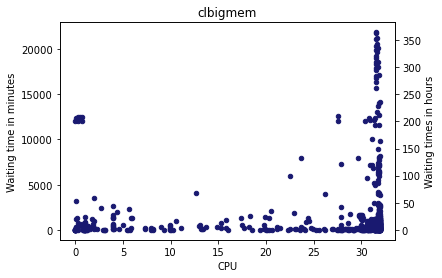

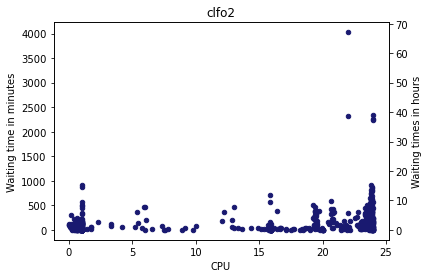

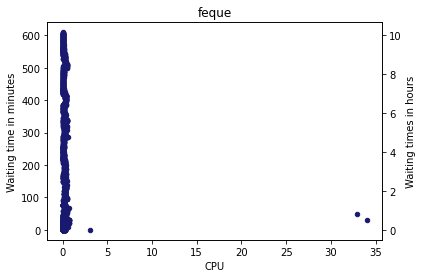

In [19]:
for batch_class in batch_classes:
    Scatter(jobs_waited,'CPU',batch_class)

In [23]:
def Bin_plot(df, x, batch_class):
    ax1 = df.loc[df['Batch_class'].str.contains(batch_class)].plot.hexbin(x=x,y='Waited')
    ax1.set_title(batch_class)
    ax1.set_ylabel('Waiting time in minutes')

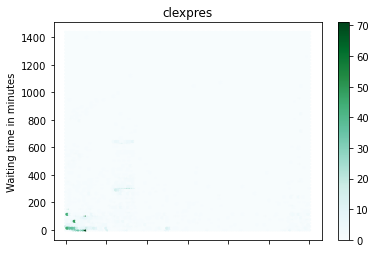

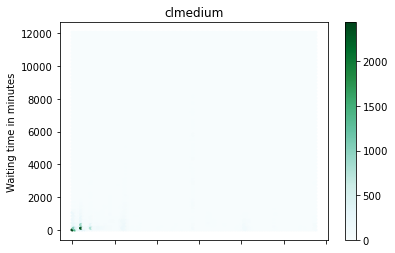

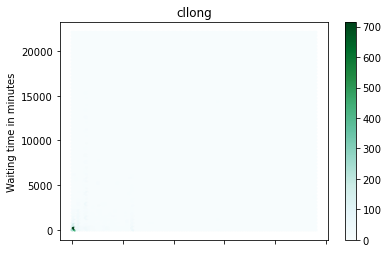

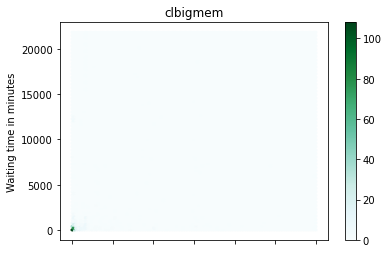

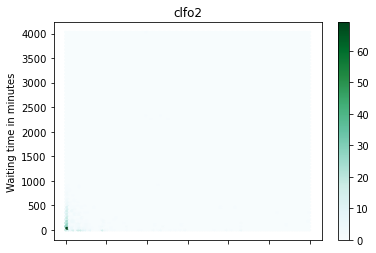

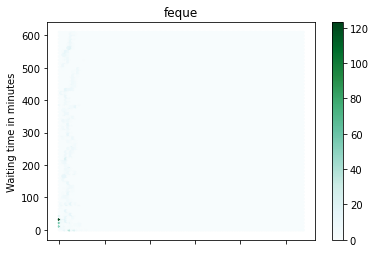

In [24]:
for batch_class in batch_classes:
    Bin_plot(jobs_waited,'Duration',batch_class)